In [6]:
from __future__ import print_function
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [7]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [8]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [9]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [10]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


TypeError: Unexpected type <class 'numpy.ndarray'>

NameError: name 'images' is not defined

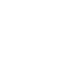

In [12]:
# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [13]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [14]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             160
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1

In [15]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [16]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.18636178970336914 Batch_id=468 Accuracy=82.36: 100%|██████████████████████████| 469/469 [00:06<00:00, 68.57it/s]



Test set: Average loss: 0.1682, Accuracy: 9532/10000 (95.32%)

EPOCH: 1


Loss=0.03455320745706558 Batch_id=468 Accuracy=97.18: 100%|██████████████████████████| 469/469 [00:06<00:00, 69.25it/s]



Test set: Average loss: 0.0478, Accuracy: 9863/10000 (98.63%)

EPOCH: 2


Loss=0.07625601440668106 Batch_id=468 Accuracy=97.76: 100%|██████████████████████████| 469/469 [00:06<00:00, 72.28it/s]



Test set: Average loss: 0.0389, Accuracy: 9878/10000 (98.78%)

EPOCH: 3


Loss=0.04655313491821289 Batch_id=468 Accuracy=98.00: 100%|██████████████████████████| 469/469 [00:06<00:00, 69.08it/s]



Test set: Average loss: 0.0389, Accuracy: 9889/10000 (98.89%)

EPOCH: 4


Loss=0.07759273052215576 Batch_id=468 Accuracy=98.30: 100%|██████████████████████████| 469/469 [00:06<00:00, 70.75it/s]



Test set: Average loss: 0.0340, Accuracy: 9902/10000 (99.02%)

EPOCH: 5


Loss=0.06151990965008736 Batch_id=468 Accuracy=98.37: 100%|██████████████████████████| 469/469 [00:06<00:00, 73.82it/s]



Test set: Average loss: 0.0332, Accuracy: 9884/10000 (98.84%)

EPOCH: 6


Loss=0.011886026710271835 Batch_id=468 Accuracy=98.45: 100%|█████████████████████████| 469/469 [00:06<00:00, 71.88it/s]



Test set: Average loss: 0.0265, Accuracy: 9913/10000 (99.13%)

EPOCH: 7


Loss=0.037129517644643784 Batch_id=468 Accuracy=98.50: 100%|█████████████████████████| 469/469 [00:06<00:00, 71.24it/s]



Test set: Average loss: 0.0276, Accuracy: 9909/10000 (99.09%)

EPOCH: 8


Loss=0.03314478322863579 Batch_id=468 Accuracy=98.58: 100%|██████████████████████████| 469/469 [00:06<00:00, 70.77it/s]



Test set: Average loss: 0.0331, Accuracy: 9893/10000 (98.93%)

EPOCH: 9


Loss=0.08407791703939438 Batch_id=468 Accuracy=98.67: 100%|██████████████████████████| 469/469 [00:06<00:00, 71.07it/s]



Test set: Average loss: 0.0227, Accuracy: 9926/10000 (99.26%)

EPOCH: 10


Loss=0.05896296724677086 Batch_id=468 Accuracy=98.69: 100%|██████████████████████████| 469/469 [00:06<00:00, 70.84it/s]



Test set: Average loss: 0.0299, Accuracy: 9910/10000 (99.10%)

EPOCH: 11


Loss=0.05998995527625084 Batch_id=468 Accuracy=98.67: 100%|██████████████████████████| 469/469 [00:06<00:00, 71.04it/s]



Test set: Average loss: 0.0251, Accuracy: 9920/10000 (99.20%)

EPOCH: 12


Loss=0.06102645769715309 Batch_id=468 Accuracy=98.73: 100%|██████████████████████████| 469/469 [00:06<00:00, 71.71it/s]



Test set: Average loss: 0.0266, Accuracy: 9917/10000 (99.17%)

EPOCH: 13


Loss=0.06358137726783752 Batch_id=468 Accuracy=98.77: 100%|██████████████████████████| 469/469 [00:06<00:00, 71.84it/s]



Test set: Average loss: 0.0286, Accuracy: 9905/10000 (99.05%)

EPOCH: 14


Loss=0.006542237941175699 Batch_id=468 Accuracy=98.79: 100%|█████████████████████████| 469/469 [00:06<00:00, 67.13it/s]



Test set: Average loss: 0.0273, Accuracy: 9909/10000 (99.09%)

